# Sentiment Analysis on aggregated data

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', None) 

In [26]:
df = pd.read_csv('aggregated_sample.csv', index_col = [0])

In [27]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

sentiment = []
index = -1
for sentence in df['review_lower']:
    index+=1
    if(index%20 == 0):
        print(index)

    result = sentiment_pipeline(sentence[:512])[0]
    sentiment.append(result['label'])
df['sentiment'] = sentiment

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


# Zero shot classification

In [28]:
import transformers
from transformers import pipeline
classifier  = pipeline("zero-shot-classification",  model = "facebook/bart-large-mnli")

# Insert four labels (cost, efficient, effective, ease of use)

In [29]:
type = ['cost', 'efficient', 'effective', 'ease of use']

In [30]:
#setting empty values for the columns
index = -1
for label in type:
    df[label + '_m'] = -1

for j in range(len(df)):
    #counter for progress/debugging
    index+=1
    if(index%20 == 0): 
        print(index)
        
    #running the classifier on the column    
    res = classifier(
        df.iloc[j]['review_lower'],
        candidate_labels = type,
        multi_label = True
    )
    #setting the column values according to the output from the classifier ("_m" = multiclass)
    for i in range(len(res['labels'])):
        df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]

0


C:\Users\Woon\AppData\Local\Temp\ipykernel_28328\576072882.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]


20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


# Metric and sanity check

['however, i should have done a price comparison before buying. this product sells for less than half at the local store. im sure its a wonderful product for plants and grass. ill be buying this at the local home depot/lowes.']

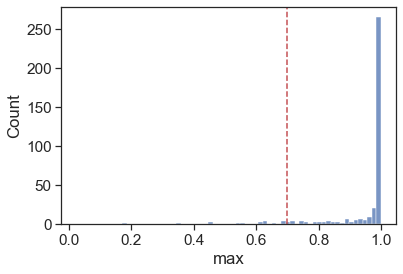

In [31]:
# create a "max" column for metric purposes
df['max'] = df[['cost_m', 'efficient_m', 'effective_m', 'ease of use_m']].max(axis=1)

# # append type to max
# align_list=[]
# for i in range(len(df)):
#   for t in type:
#     if df[t+'_m'].iloc[i] == df['max'].iloc[i]:
#       align_list.append(t)
      
# df['align_type']=align_list


sns.set_style('ticks');
fig, ax = plt.subplots();
ax = sns.histplot(x = 'max', data = df);
plt.axvline(0.7, 0,700, c = 'r', ls = '--');

list(df[df['max'] > 0.7]['review_lower'][1:2])

# How many remained uncategorized

In [32]:
df['other_m'] = 0
for row in range(len(df)):
    if df.at[row, 'max'] < 0.7:
        df.at[row, 'other_m'] = 1

In [33]:
def imputation(list):
    i = []
    for prediction in list:
        if prediction < 0.7:
            i.append(0)
        else:
            i.append(1)
    
    return(i)
df['cost_m'] = imputation(df['cost_m'])
df['efficient_m'] = imputation(df['efficient_m'])
df['effective_m'] = imputation(df['effective_m'])
df['ease of use_m'] = imputation(df['ease of use_m'])

In [34]:
df['cost_m'] = df['cost_m'].replace(1, 'cost')
df['cost_m'] = df['cost_m'].replace(0, '')
df['efficient_m'] = df['efficient_m'].replace(1, 'efficient')
df['efficient_m'] = df['efficient_m'].replace(0, '')
df['effective_m'] = df['effective_m'].replace(1, 'effective')
df['effective_m'] = df['effective_m'].replace(0, '')
df['ease of use_m'] = df['ease of use_m'].replace(1, 'ease of use')
df['ease of use_m'] = df['ease of use_m'].replace(0, '')
df['other_m'] = df['other_m'].replace(1, 'other')
df['other_m'] = df['other_m'].replace(0, '')

In [35]:
align_list=[]
for i in range(len(df)):
    interim_list = []
    interim_list = (df.iloc[i][26],df.iloc[i][27],df.iloc[i][28],df.iloc[i][29],df.iloc[i][31])
    align_list.append(interim_list)
df['align_type']=align_list

In [36]:
df.to_csv('true_df.csv')

# Heatmap

In [167]:
df = pd.read_csv('true_df.csv')

In [169]:
df['align_type'] = df['align_type'].replace('(\'cost\', \'\', \'\', \'\', \'\')', 'cost')
df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'\', \'\', \'\')', 'efficient')
df['align_type'] = df['align_type'].replace('(\'\', \'\', \'effective\', \'\', \'\')', 'effective')
df['align_type'] = df['align_type'].replace('(\'\', \'\', \'\', \'ease of use\', \'\')', 'ease of use')
df['align_type'] = df['align_type'].replace('(\'\', \'\', \'\', \'\', \'other\')', 'other')

df['align_type'] = df['align_type'].replace('(\'cost\', \'efficient\', \'\', \'\', \'\')', 'cost, efficient')
df['align_type'] = df['align_type'].replace('(\'cost\', \'\', \'effective\', \'\', \'\')', 'cost, effective')
df['align_type'] = df['align_type'].replace('(\'cost\', \'\', \'\', \'ease of use\', \'\')', 'cost, ease of use')
df['align_type'] = df['align_type'].replace('(\'cost\', \'\', \'\', \'\', \'other\')', 'cost, other')

df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'effective\', \'\', \'\')', 'efficient, effective')
df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'\', \'ease of use\', \'\')', 'efficient, ease of use')
df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'\', \'\', \'other\')', 'efficient, other')

df['align_type'] = df['align_type'].replace('(\'\', \'\', \'effective\', \'ease of use\', \'\')', 'effective, ease of use')
df['align_type'] = df['align_type'].replace('(\'\', \'\', \'effective\', \'\', \'other\')', 'effective, other')

df['align_type'] = df['align_type'].replace('(\'\', \'\', \'\', \'ease of use\', \'other\')', 'ease of use, other')

df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'effective\', \'\', \'\')', 'efficient, effective')

df['align_type'] = df['align_type'].replace('(\'cost\', \'efficient\', \'effective\', \'\', \'\')', 'cost, efficient, effective')
df['align_type'] = df['align_type'].replace('(\'cost\', \'\', \'effective\', \'ease of use\', \'\')', 'cost, effective, ease of use')
df['align_type'] = df['align_type'].replace('(\'cost\', \'\', \'\', \'ease of use\', \'other\')', 'cost, ease of use, other')

df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'effective\', \'ease of use\', \'\')', 'efficient, effective, ease of use')
df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'\', \'ease of use\', \'other\')', 'efficient, ease of use, other')

df['align_type'] = df['align_type'].replace('(\'\', \'\', \'effective\', \'ease of use\', \'other\')', 'effective, ease of use, other')

df['align_type'] = df['align_type'].replace('(\'cost\', \'efficient\', \'effective\', \'ease of use\', \'\')', 'cost, efficient, effective, ease of use')
df['align_type'] = df['align_type'].replace('(\'\', \'efficient\', \'effective\', \'ease of use\', \'other\')', 'efficient, effective, ease of use, other')

df['align_type'] = df['align_type'].replace('(\'cost\', \'efficient\', \'effective\', \'ease of use\', \'other\')', 'cost, efficient, effective, ease of use, other')

In [170]:
df2=df.groupby(['align_type', 'sentiment'])['align_type'].count().rename("count").groupby(level = 0).transform(lambda x: x/400*100).reset_index(name = 'count %')

<Figure size 864x360 with 0 Axes>

[Text(0.5, 17.5, ''), Text(80.5, 0.5, '')]

[Text(0.5, -211.875, ''), Text(80.5, 0.5, '')]

[Text(0.5, -211.875, ''), Text(80.5, 0.5, '')]

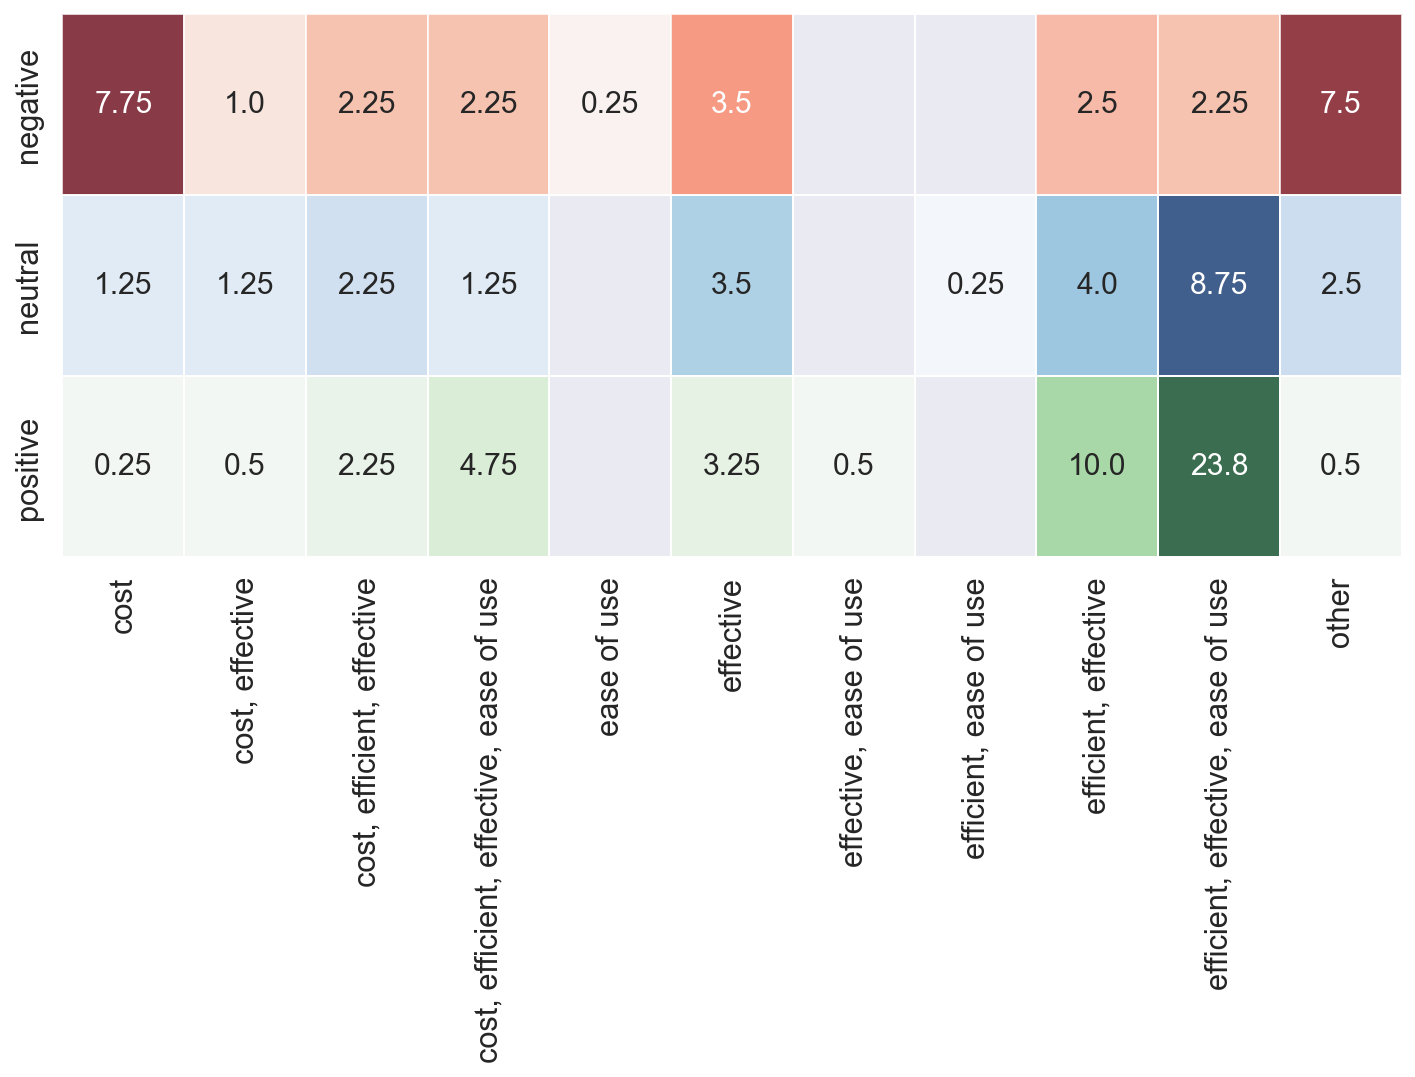

In [171]:
table = pd.pivot_table(df2, values='count %', index=['sentiment'], columns=['align_type'])

plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
# Reds
data1 = table.copy()
data1.loc['negative'] = float('nan')
data1.loc['neutral'] = float('nan')
ax=sns.heatmap(data1, annot=True, cmap="Greens", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Blue
data2 = table.copy()
data2.loc['negative'] = float('nan')
data2.loc['positive'] = float('nan')
ax=sns.heatmap(data2, annot=True, cmap="Blues", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")
# Greens
data3 = table.copy()
data3.loc['positive'] = float('nan')
data3.loc['neutral'] = float('nan')
ax=sns.heatmap(data3, annot=True, cmap="Reds", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

In [172]:
df3=df.groupby(['align_type', 'sentiment'])['align_type'].count().rename("count").groupby(level = 0).transform(lambda x: x/x.sum()*100).reset_index(name = 'count %')

<Figure size 864x360 with 0 Axes>

[Text(0.5, 17.5, ''), Text(80.5, 0.5, '')]

[Text(0.5, -211.875, ''), Text(80.5, 0.5, '')]

[Text(0.5, -211.875, ''), Text(80.5, 0.5, '')]

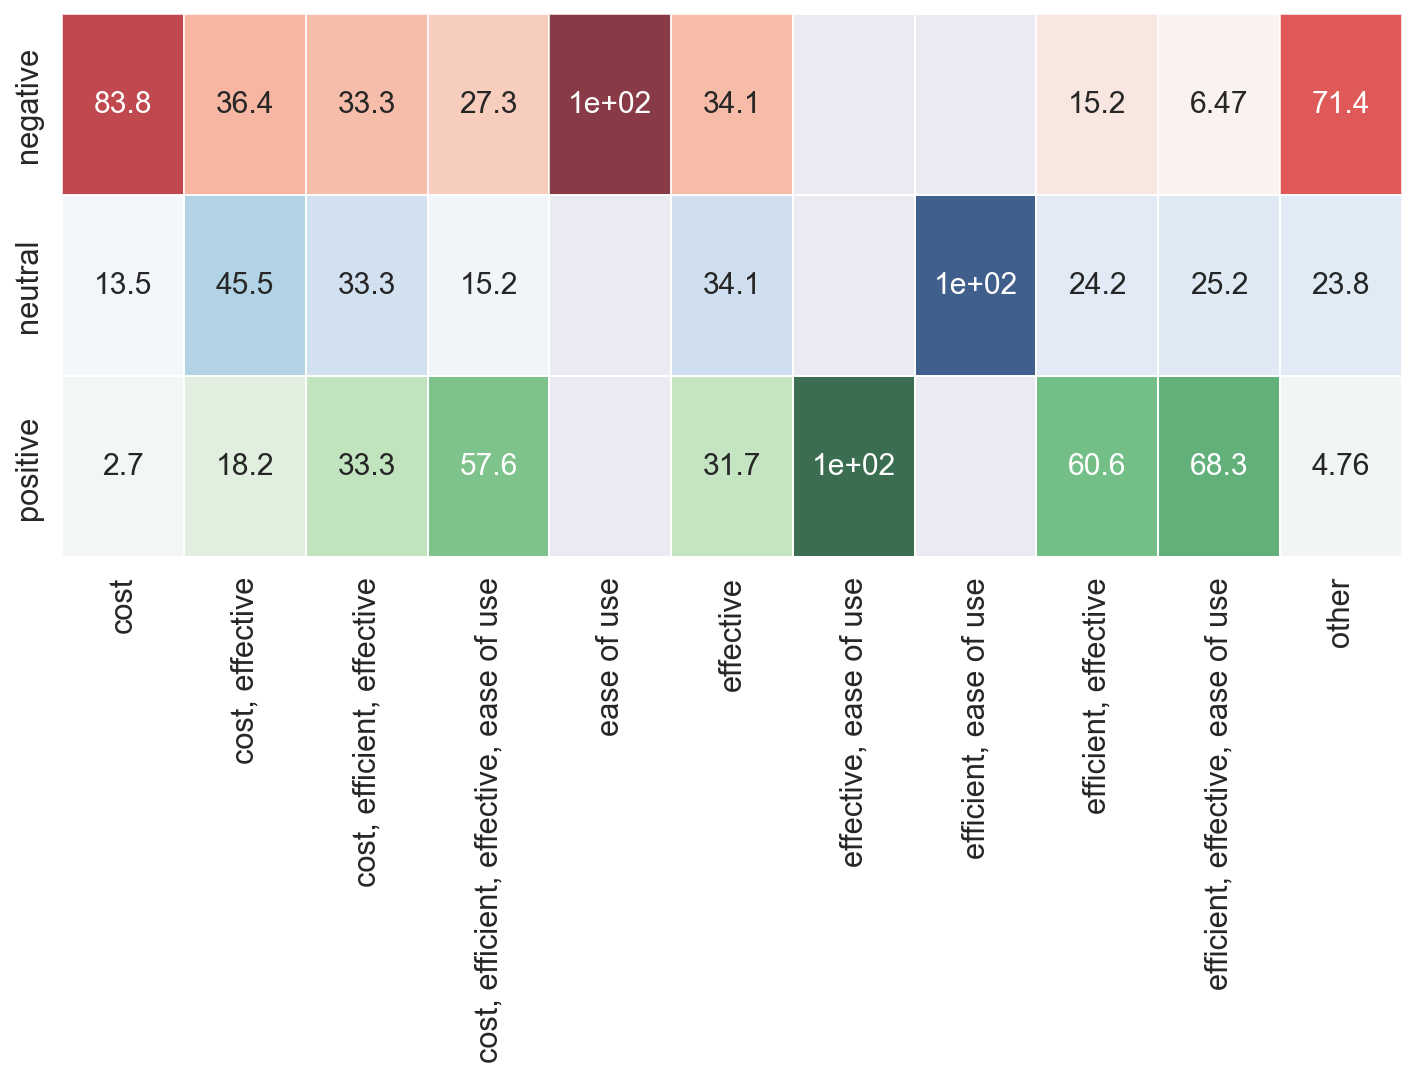

In [173]:
table = pd.pivot_table(df3, values='count %', index=['sentiment'], columns=['align_type'])

plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
# Reds
data1 = table.copy()
data1.loc['negative'] = float('nan')
data1.loc['neutral'] = float('nan')
ax=sns.heatmap(data1, annot=True, cmap="Greens", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Blue
data2 = table.copy()
data2.loc['negative'] = float('nan')
data2.loc['positive'] = float('nan')
ax=sns.heatmap(data2, annot=True, cmap="Blues", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")
# Greens
data3 = table.copy()
data3.loc['positive'] = float('nan')
data3.loc['neutral'] = float('nan')
ax=sns.heatmap(data3, annot=True, cmap="Reds", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

In [174]:
# Treemap
from collections import defaultdict
import plotly
import plotly.express as px

data =  df
fig = px.treemap(data, path=['sentiment_m', 'align_type'])

fig.data[0].textinfo = 'label+text+percent parent'
fig.data[0]['textfont']['color'] = "white"
fig.data[0]['textfont']['size'] = 15
fig.data[0].textposition = 'middle center'

fig.layout.hovermode = False

fig.show()

ValueError: Value of 'path_0' is not the name of a column in 'data_frame'. Expected one of ['Unnamed: 0', 'segment', 'review_id', 'product_name', 'producturl', 'retailer', 'brand', 'retailer_product_id', 'base_id', 'variants_flag', 'review_creation_date', 'year', 'month', 'week', 'review_title', 'review_text', 'review_type', 'price', 'rating', 'images', 'videos', 'helpful_votes', 'promotion_flag', 'review_lower', 'date', 'word_count', 'sentiment', 'cost_m', 'efficient_m', 'effective_m', 'ease of use_m', 'max', 'other_m', 'align_type'] but received: sentiment_m

# Accuracy evaluation

In [98]:
df = pd.read_csv('aggregated_handlabeled.csv', index_col = [0])
#replace NaN in label columns with 0
columns = ['cost','ease of use', 'effective', 'efficient']

for column in columns:
    df[column] = df[column].replace(np.nan, '0')

In [99]:
# sentiment analysis
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

sentiment = [None] * len(df)
index = -1
for sentence in df['review_lower'][0:99]:
    index+=1
    if(index%20 == 0):
        print(index)

    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
df['sentiment_m'] = sentiment

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
20
40
60
80


In [100]:
# zero-shot classifier
classifier  = pipeline("zero-shot-classification",  model = "facebook/bart-large-mnli")
type = ['cost', 'efficient', 'effective', 'ease of use']
#setting empty values for the columns
index = -1
for label in type:
    df[label + '_m'] = -1

for j in range(99):
    #counter for progress/debugging
    index+=1
    if(index%20 == 0): 
        print(index)
        
    #running the classifier on the column    
    res = classifier(
        df.iloc[j]['review_lower'],
        candidate_labels = type,
        multi_label = True
    )
    #setting the column values according to the output from the classifier ("_m" = multiclass)
    for i in range(len(res['labels'])):
        df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]

0


C:\Users\Woon\AppData\Local\Temp\ipykernel_28328\2091210579.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



20
40
60
80


## Evaluate sentiment

In [101]:
# Evaluate sentiment
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
def imputation1(list):
    i = []
    for prediction in list:
        if prediction == "positive":
            i.append(1)
        elif prediction == "neutral":
            i.append(0)
        else:
            i.append(-1)    
    return(i)
df['sentiment'] = imputation1(df['sentiment'])
df['sentiment_m'] = imputation1(df['sentiment_m'])
print(classification_report(df['sentiment'], df['sentiment_m']))

              precision    recall  f1-score   support

          -1       0.95      0.99      0.97       309
           0       0.08      0.29      0.13         7
           1       0.93      0.62      0.74        84

    accuracy                           0.90       400
   macro avg       0.66      0.63      0.61       400
weighted avg       0.93      0.90      0.91       400



## Evaluate zero shot

In [102]:
# Evaluate zero-shot
def imputation(list):
    i = []
    for prediction in list:
        if prediction < 0.7:
            i.append(0)
        else:
            i.append(1)
    
    return(i)
df['cost_m'] = imputation(df['cost_m'])
df['efficient_m'] = imputation(df['efficient_m'])
df['effective_m'] = imputation(df['effective_m'])
df['ease of use_m'] = imputation(df['ease of use_m'])

### 1) cost

In [112]:
df['cost'] = df['cost'].astype(int)
df['efficient'] = df['efficient'].astype(int)
df['effective'] = df['effective'].astype(int)
df['ease of use'] = df['ease of use'].astype(int)

In [110]:
print(classification_report(df['cost'], df['cost_m']))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       393
           1       0.26      0.86      0.40         7

    accuracy                           0.95       400
   macro avg       0.63      0.91      0.69       400
weighted avg       0.98      0.95      0.97       400



### 2) efficient

In [113]:
print(classification_report(df['efficient'], df['efficient_m']))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       349
           1       0.49      0.76      0.60        51

    accuracy                           0.87       400
   macro avg       0.73      0.83      0.76       400
weighted avg       0.90      0.87      0.88       400



### 3) effective

In [114]:
print(classification_report(df['effective'], df['effective_m']))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       311
           1       0.88      0.92      0.90        89

    accuracy                           0.95       400
   macro avg       0.93      0.94      0.94       400
weighted avg       0.96      0.95      0.96       400



### 4) ease of use

In [115]:
print(classification_report(df['ease of use'], df['ease of use_m']))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       376
           1       0.31      0.71      0.44        24

    accuracy                           0.89       400
   macro avg       0.65      0.80      0.69       400
weighted avg       0.94      0.89      0.91       400



## Compare zero-shot against a Naive classifier

In [116]:
def naive(list):
    avg  = np.mean(list)

    if avg >= 0.5:
        i = 1
    else:
        i = 0

    return([i] * len(list))
df['naive_cost'] = naive(df['cost'])
df['naive_efficient'] = naive(df['efficient'])
df['naive_effective'] = naive(df['effective'])
df['naive_easeofuse'] = naive(df['ease of use'])

In [117]:
# cost
print(classification_report(df['cost'], df['naive_cost']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       393
           1       0.00      0.00      0.00         7

    accuracy                           0.98       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.97      0.98      0.97       400



c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [118]:
# efficient
print(classification_report(df['efficient'], df['naive_efficient']))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       349
           1       0.00      0.00      0.00        51

    accuracy                           0.87       400
   macro avg       0.44      0.50      0.47       400
weighted avg       0.76      0.87      0.81       400



c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [119]:
# effective
print(classification_report(df['effective'], df['naive_effective']))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87       311
           1       0.00      0.00      0.00        89

    accuracy                           0.78       400
   macro avg       0.39      0.50      0.44       400
weighted avg       0.60      0.78      0.68       400



c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [120]:
# ease of use
print(classification_report(df['ease of use'], df['naive_easeofuse']))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       376
           1       0.00      0.00      0.00        24

    accuracy                           0.94       400
   macro avg       0.47      0.50      0.48       400
weighted avg       0.88      0.94      0.91       400



c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [127]:
report_sentiment = classification_report(df['sentiment'], df['sentiment_m'], output_dict=True)

def accuracy(type):
  report = classification_report(df[type], df[type+'_m'], output_dict=True)
  return (type, report['1']['recall'])

def accuracy_matrix(type):
  report = classification_report(df[type], df[type+'_m'], output_dict=True)
  data= np.ones((100, 100))
  data[0:int(report_sentiment['accuracy']*100),0:int(report['1']['recall']*100)] = 0.0 
  return data

In [128]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.ticker as mticker  
import matplotlib.patches as mpatches

Text(0.5, 0, 'cost accuracy')

Text(0, 0.5, 'sentiment accuracy')

Text(0, 0.5, 'sentiment accuracy')

Text(0.5, 0, 'ease of use accuracy')

Text(0.5, 0, 'effectiveness accuracy')

Text(0.5, 0, 'efficiency accuracy')

Text(40, 45, 'Accuracy: 76.93%')

Text(40, 45, 'Accuracy: 63.57%')

Text(40, 45, 'Accuracy: 82.69%')

Text(40, 45, 'Accuracy: 68.63%')

[]

[]

[]

[]

[]

[]

[]

[]

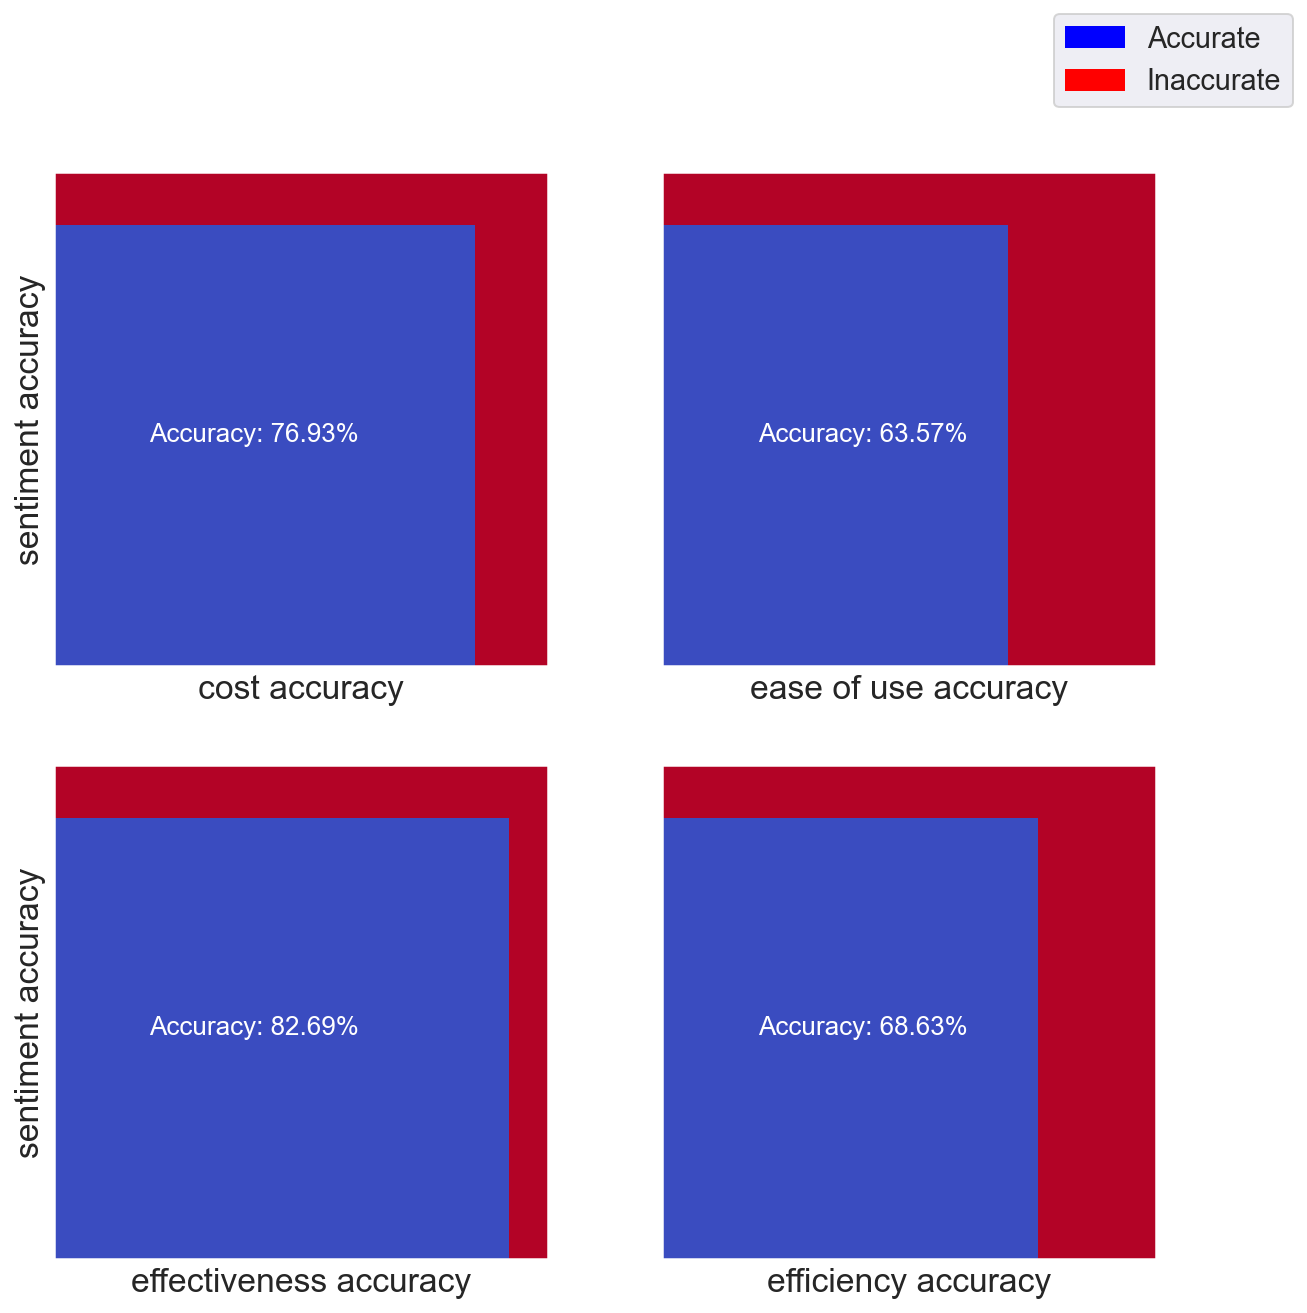

In [129]:
#fig, ax = plt.subplots()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)

fig.set_figheight(10)
fig.set_figwidth(10)

img1 = ax1.imshow(accuracy_matrix('cost'),cmap='coolwarm',origin='lower')
img2 = ax2.imshow(accuracy_matrix('ease of use'),cmap='coolwarm',origin='lower')
img3 = ax3.imshow(accuracy_matrix('effective'),cmap='coolwarm',origin='lower')
img4 = ax4.imshow(accuracy_matrix('efficient'),cmap='coolwarm',origin='lower')

img1=plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
img1=plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())

ax1.set_xlabel('cost accuracy')
ax1.set_ylabel('sentiment accuracy')
ax3.set_ylabel('sentiment accuracy')
ax2.set_xlabel('ease of use accuracy')
ax3.set_xlabel('effectiveness accuracy')
ax4.set_xlabel('efficiency accuracy')

ax1.text(40, 45, 'Accuracy: '+ str(round(report_sentiment['accuracy']*accuracy('cost')[1]*100,2))+'%', fontsize=13, c='white',ha='center')
ax2.text(40, 45, 'Accuracy: '+ str(round(report_sentiment['accuracy']*accuracy('ease of use')[1]*100,2))+'%', fontsize=13, c='white',ha='center')
ax3.text(40, 45, 'Accuracy: '+ str(round(report_sentiment['accuracy']*accuracy('effective')[1]*100,2))+'%', fontsize=13, c='white',ha='center')
ax4.text(40, 45, 'Accuracy: '+ str(round(report_sentiment['accuracy']*accuracy('efficient')[1]*100,2))+'%', fontsize=13, c='white',ha='center')

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])

blue_patch = mpatches.Patch(color='blue', label='Accurate')
red_patch = mpatches.Patch(color='red', label='Inaccurate')
fig.legend(handles=[blue_patch, red_patch],loc='upper right',fontsize='x-large')

# For 5 star rating reviews

In [134]:
df_5 = df[df['rating'] == 5]

Text(0.5, 1.0, 'Top 10 Products with 5 Ratings')

<AxesSubplot:title={'center':'Top 10 Products with 5 Ratings'}, xlabel='count', ylabel='product_name'>

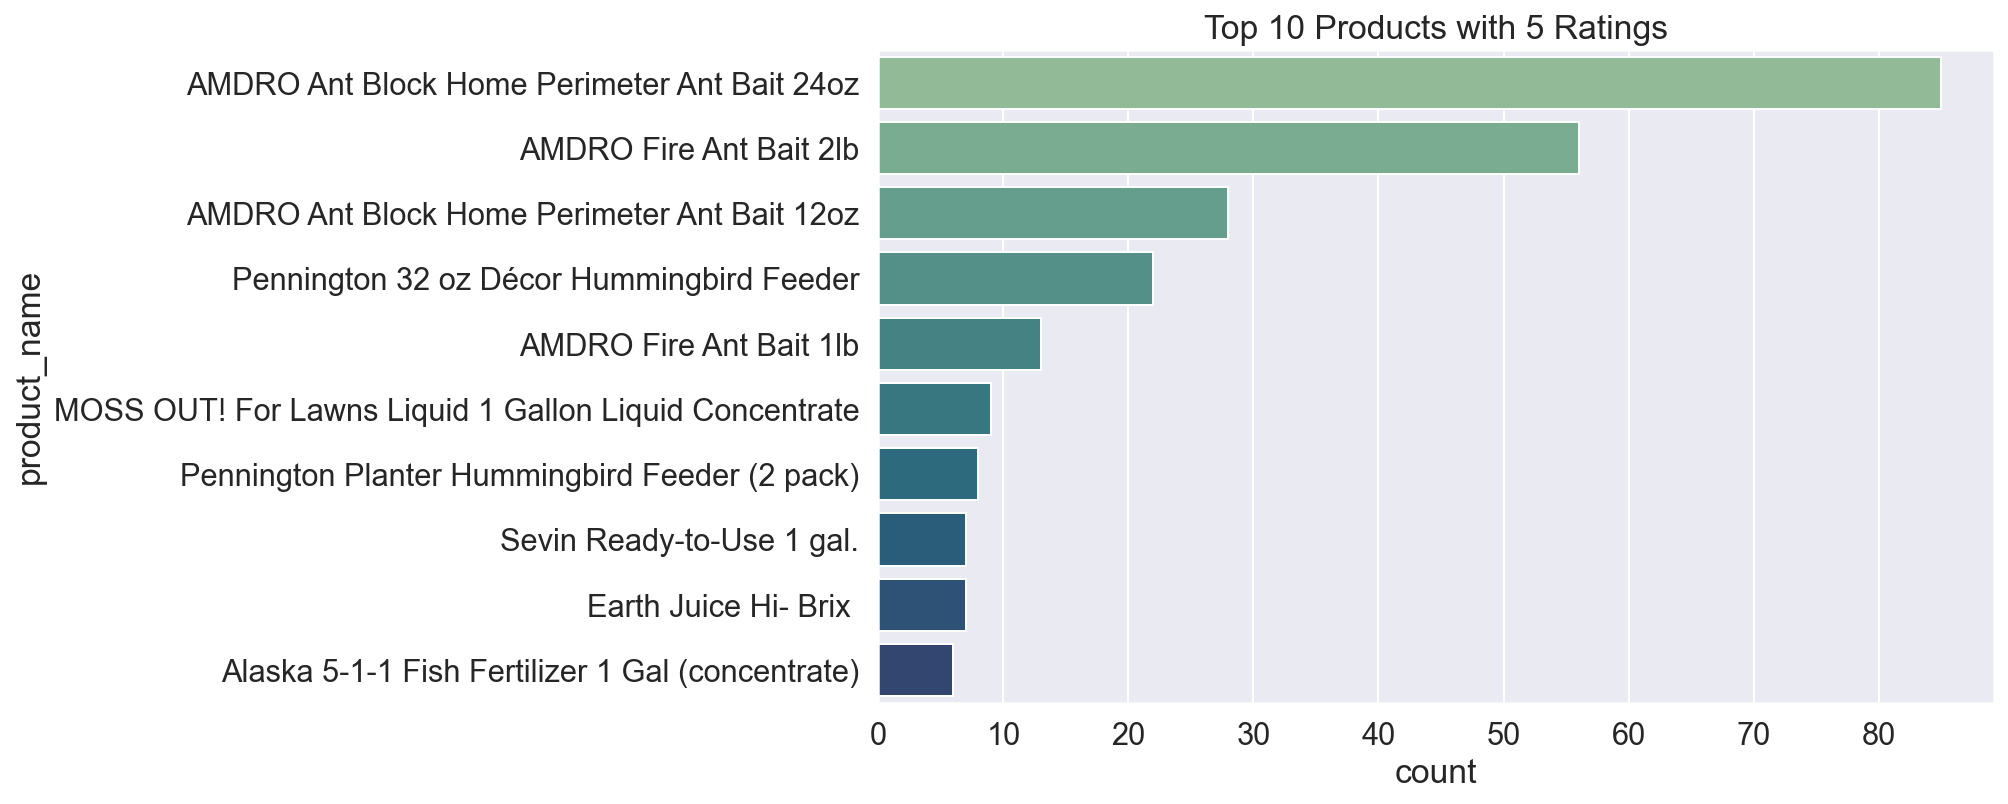

In [156]:
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
plt.title('Top 10 Products with 5 Ratings');
sns.countplot(y = 'product_name', data = df_5, order = df_5['product_name'].value_counts()[0:10].index, palette=sns.color_palette("crest", n_colors=10))
#plt.savefig('figs/negative_homedepot', bbox_inches = 'tight');

# N-gram

In [157]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [181]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in df_5["review_lower"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Bi-Gram of 5 star reviews")
py.iplot(fig, filename='word-plots');

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# For 1 Star Rated Reviews

In [159]:
df_1 = df[df['rating'] == 1]

Text(0.5, 1.0, 'Top 10 Products with 1 Ratings')

<AxesSubplot:title={'center':'Top 10 Products with 1 Ratings'}, xlabel='count', ylabel='product_name'>

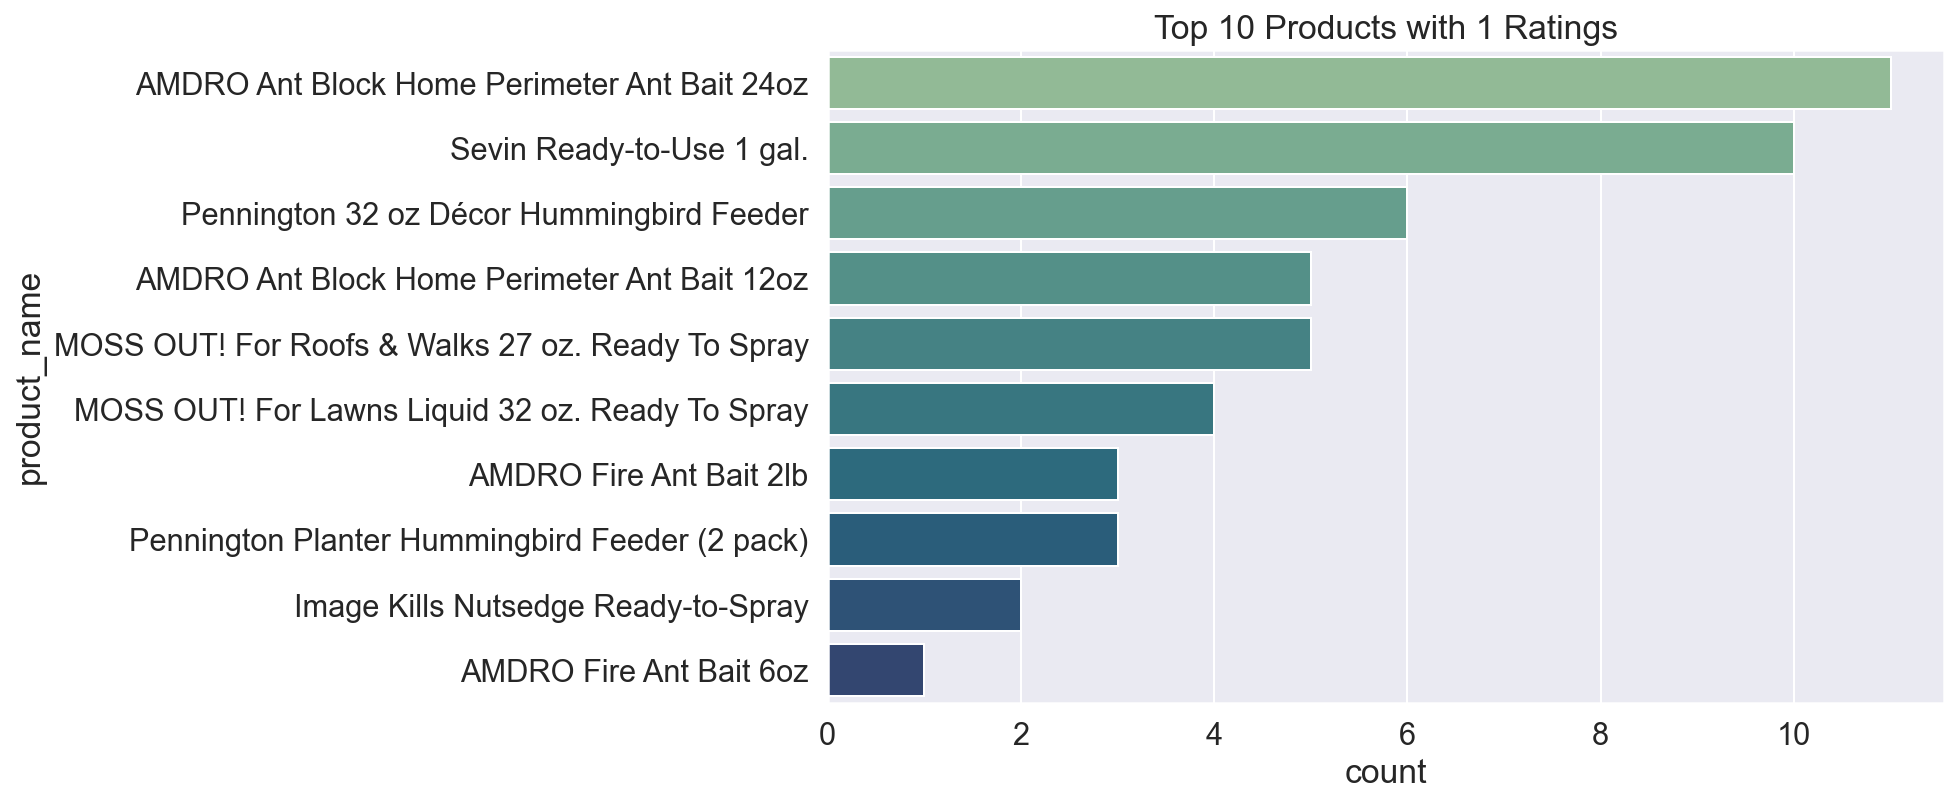

In [160]:
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
plt.title('Top 10 Products with 1 Ratings');
sns.countplot(y = 'product_name', data = df_1, order = df_1['product_name'].value_counts()[0:10].index, palette=sns.color_palette("crest", n_colors=10))
#plt.savefig('figs/negative_homedepot', bbox_inches = 'tight');

In [180]:
## Get the bar chart from 1 rated reviews ##
freq_dict = defaultdict(int)
for sent in df_1["review_lower"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Bi-Gram of 1 star reviews")
py.iplot(fig, filename='word-plots');

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [163]:
# Treemap
from collections import defaultdict
import plotly
import plotly.express as px

data =  df
fig = px.treemap(data, path=['sentiment_m', 'align_type'])

fig.data[0].textinfo = 'label+text+percent parent'
fig.data[0]['textfont']['color'] = "white"
fig.data[0]['textfont']['size'] = 15
fig.data[0].textposition = 'middle center'

fig.layout.hovermode = False

fig.show()

ValueError: Value of 'path_1' is not the name of a column in 'data_frame'. Expected one of ['segment', 'review_id', 'product_name', 'producturl', 'retailer', 'brand', 'retailer_product_id', 'base_id', 'variants_flag', 'review_creation_date', 'year', 'month', 'week', 'review_title', 'review_text', 'review_type', 'price', 'rating', 'images', 'videos', 'helpful_votes', 'promotion_flag', 'review_lower', 'date', 'word_count', 'sentiment', 'cost', 'ease of use', 'effective', 'efficient', 'sentiment_m', 'cost_m', 'efficient_m', 'effective_m', 'ease of use_m', 'naive_cost', 'naive_efficient', 'naive_effective', 'naive_easeofuse'] but received: align_type

In [162]:
df.to_csv('aggregated_evaluation.csv')